In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.parser import Application
from sklearn.preprocessing import MinMaxScaler
sns.set()

In [2]:
app = Application()
scaler = MinMaxScaler()

In [7]:
rawData = app.Import('dataset/rawdata')
rawData.head()

,Date,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Payment,cogs,gross margin percentage,gross income,Rating
0,1/5/2019,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,Ewallet,522.83,4.761905,26.1415,9.1
1,3/8/2019,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,76.40,4.761905,3.8200,9.6
2,3/3/2019,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,324.31,4.761905,16.2155,7.4
3,1/27/2019,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,Ewallet,465.76,4.761905,23.2880,8.4
4,2/8/2019,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,Ewallet,604.17,4.761905,30.2085,5.3


In [28]:
rawData['Date'] = pd.to_datetime(rawData['Date']).dt.date
rawData = rawData.groupby('Date').sum()

In [29]:
trainingData, testingData = app.Split(rawData)

In [30]:
trainingSet = scaler.fit_transform(trainingData.reshape(-1, 1))
xTrain, yTrain = app.TrainingSplit(trainingSet)

In [31]:
inputs = app.GetInputs(trainingData, testingData, days = 1)
inputs = scaler.fit_transform(inputs.reshape(-1, 1))

In [32]:
xTest, yTest = app.TestingSplit(inputs, 1, len(testingData))

In [33]:
xTrain = app.Reshape(xTrain, 1)
xTest = app.Reshape(xTest, 1)

In [34]:
print(xTest.shape, xTrain.shape)

(18, 1, 1) (70, 1, 1)


## Network

In [36]:
import tensorflow as tf

In [37]:
tf.__version__

'2.4.1'

In [38]:
model = tf.keras.models.Sequential()

In [39]:
units = 50
dropout = 0.25

In [40]:
model.add(tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(xTrain.shape[1], 1)))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.LSTM(units=units, return_sequences=True))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.LSTM(units=units, return_sequences=True))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.LSTM(units=units))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(units=1))

In [41]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x=xTrain, y=yTrain, epochs=100, batch_size=32, validation_data=(xTest, yTest), callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=2,
        mode='min',
        restore_best_weights=True)])

Epoch 1/100
3/3 [==============================] - 7s 791ms/step - loss: 0.2098 - val_loss: 0.1798
Epoch 2/100
3/3 [==============================] - 0s 73ms/step - loss: 0.2274 - val_loss: 0.1718
Epoch 3/100
3/3 [==============================] - 0s 72ms/step - loss: 0.2099 - val_loss: 0.1635
Epoch 4/100
3/3 [==============================] - 0s 71ms/step - loss: 0.1824 - val_loss: 0.1549
Epoch 5/100
3/3 [==============================] - 0s 71ms/step - loss: 0.1963 - val_loss: 0.1457
Epoch 6/100
3/3 [==============================] - 0s 73ms/step - loss: 0.1818 - val_loss: 0.1361
Epoch 7/100
3/3 [==============================] - 0s 71ms/step - loss: 0.1602 - val_loss: 0.1259
Epoch 8/100
3/3 [==============================] - 0s 75ms/step - loss: 0.1585 - val_loss: 0.1150
Epoch 9/100
3/3 [==============================] - 0s 93ms/step - loss: 0.1382 - val_loss: 0.1037
Epoch 10/100
3/3 [==============================] - 0s 83ms/step - loss: 0.1238 - val_loss: 0.0925
Epoch 11/100
3/3 [

In [42]:
prediction = model.predict(xTest)
prediction = scaler.inverse_transform(prediction)
yTest = scaler.inverse_transform(yTest.reshape(-1, 1))

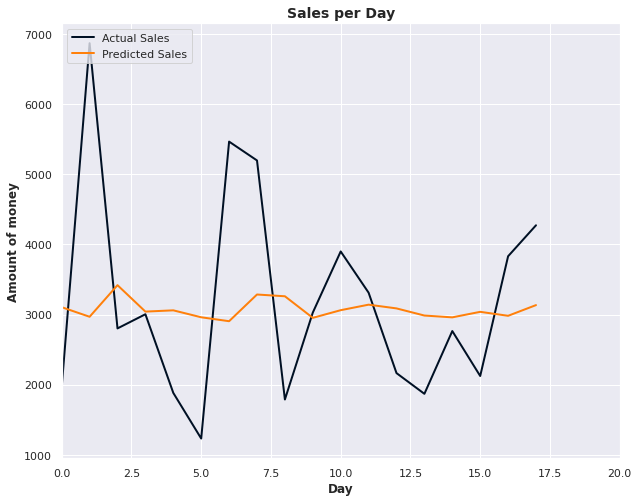

In [47]:
plt.figure(figsize=(10, 8))

plt.plot(yTest, color='#001024', label = 'Actual Sales', linewidth=2)
plt.plot(prediction, color="#FF800B", label = 'Predicted Sales', linewidth = 2)

plt.title('Sales per Day', fontsize = 14, fontweight = 'bold')
plt.xlabel('Day', fontsize = 12, fontweight = 'bold')
plt.xlim(left=int(0), right=int(20))
plt.ylabel('Amount of money', fontsize = 12, fontweight = 'bold')
plt.legend(loc='upper left')

plt.show()